# Задача 9. Эксперименты: Статика vs. Динамика

В данной задаче требуется сравнить производительность трех алгоритмов для поиска кратчайших путей от одной вершины до всех остальных в изменяющемся графе. Граф является невзвешенным, то есть каждое ребро имеет вес, равный 1.

Перечисленные алгоритмы, которые будут сравниваться:

1. Алгебраическая версия алгоритма Беллмана-Форда, реализованная с использованием GraphBLAS.
2. Классический алгоритм Дейкстры.
3. Динамический алгоритм, который работает похожим образом на классический алгоритм Дейкстры.

Первые два алгоритма являются статическими, то есть они решают задачу одновременно для всего графа целиком. Третий алгоритм является динамическим: он вычисляет начальные расстояния с помощью второго алгоритма, а затем при последующих обновлениях использует эту информацию, чтобы не пересчитывать расстояния в тех частях графа, которые точно не были затронуты обновлениями.

**Цель работы** заключается в определении того, какой из этих алгоритмов работает быстрее на разных размерах графов, при различных процентах измененных ребер и различных способах изменений (инкрементальном, декрементальном или смешанном).

In [1]:
import random
import time
import io
import networkx as nx
import pandas as pd
import pygraphblas as gb
import seaborn as sns

from matplotlib import pyplot as plt
from PIL import Image
from itertools import zip_longest
from pathlib import Path
from typing import Hashable, Generator, Literal

from path_finder import sssp as gb_sssp
from sssp_dynamic import DynamicSSSP, dijkstra_sssp

## Оборудование


In [3]:
! printf '\nCPU\n\n'
! lscpu | grep -E 'Architecture|CPU\(s\)|Thread\(s\)|cache|Core\(s\)|MHz'
! printf '\nRAM\n\n'
! free -m


CPU

Architecture:                    x86_64
CPU(s):                          32
On-line CPU(s) list:             0-31
Thread(s) per core:              2
Core(s) per socket:              16
CPU MHz:                         4491.397
L1d cache:                       512 KiB
L1i cache:                       512 KiB
L2 cache:                        16 MiB
L3 cache:                        32 MiB

RAM

              total        used        free      shared  buff/cache   available
Mem:          24964         559       22812           0        1592       24042
Swap:          7168           0        7168


## Генерация

Для выполнения эксперимента были выбраны графы, разделенные на семь групп в зависимости от количества вершин: <=100, 1000, 5000, 10000, 25000, 50000, 100000. Первая группа содержит графы социальных сетей, с числом вершин меньше 100. Остальные графы были сгенерированы с помощью функции `nx.generators.community.random_partition_graph`, которая относительно быстро генерирует большие графы.

В каждой группе присутствуют три графа для усреднения времени работы алгоритма. Алгоритм анализируется как для графов с малыми, так и для графов с крупными сообществами. 

В графах присутствуют два типа ребер: внутри сообщества (основная часть ребер сгенерированна так, чтобы отражать связь внутри сообщества) и между сообществами.

In [2]:
directory = Path("graphs")


def _generate_and_save_small_graphs():
    """
    Generates and saves small graphs with less than 100 vertices.
    """
    directory.mkdir(exist_ok=True)
    small_graphs = [
        nx.davis_southern_women_graph().to_directed(),
        nx.les_miserables_graph().to_directed(),
        nx.karate_club_graph().to_directed()
    ]
    for i in range(len(small_graphs)):
        print('\t', small_graphs[i])
        nx.write_gexf(small_graphs[i], directory / f"100_{i + 1}.txt")
    print()


def _generate_large_graphs(num_vertices: int) -> Generator[nx.DiGraph, None, None]:
    """
    Generates large graphs with a given number of vertices. 

    Args:
        num_vertices (int): Number of vertices in the graph.

    Yields:
        Generator[nx.DiGraph, None, None]: Generated large graph.
    """
    base_prob = 0.01 if num_vertices <= 25000 else 0.001
    community_sizes = [0.1, 1, 4]  # As a percentage of total vertices

    for i, community_size in enumerate(community_sizes, start=1):
        community_size = int(num_vertices * community_size / 100)
        yield nx.gaussian_random_partition_graph(
            num_vertices, community_size, 3, base_prob * (4 // i), base_prob / (2 * i), directed=True, seed=1
        )


def generate_graphs():
    """
    Generates and saves small and large graphs for analysis.
    
    The large graphs are generated using the gaussian_random_partition_graph function. The base probability is chosen 
    based on the number of vertices, increasing the number of edges as the vertices increase. Additionally, the 
    function promotes more frequent connections within communities compared to between them. 
    """
    print("Generate small graphs:")
    _generate_and_save_small_graphs()

    print("Generate large graphs:")
    large_graph_sizes = [1000, 5000, 10000, 25000, 50000, 100000]

    for num_vertices in large_graph_sizes:
        print(f"\t{num_vertices}")
        for i, large_graph in enumerate(_generate_large_graphs(num_vertices), start=1):
            print('\t', large_graph)
            nx.write_gexf(large_graph, directory / f"{num_vertices}_{i}.txt")

#generate_graphs()

## Эксперименты


Проведем замеры времени работы различных алгоритмов на разных графах с различными процентами изменения ребер и разными методами изменения. Статические алгоритмы будут протестированы на измененных графах, при этом время изменения графа не будет учитываться. Для динамического алгоритма будет измерено время первого запроса после всех изменений, время изменения графа также не будет учитываться. 

Кроме того, не будем учитывать время преобразования графа в GraphBLAS-матрицу смежности для алгоритма, основанного на GraphBLAS, поскольку обычно графы хранятся в этом представлении изначально. 

Таким образом, будем измерять только время работы алгоритмов на конечном графе. Если будут применены смешанные обновления с добавлением и удалением ребер, то эти операции будут чередоваться в динамическом алгоритме. Кажется, порядок этих обновлений не будет оказывать влияния на результаты, так как алгоритм обрабатывает их одновременно. Заметим, что для динамического алгоритма процесс удаления в принципе сложнее, чем добавления.

In [10]:
modified_edges_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
results_file = Path("results.csv")
random.seed(1)


def save_result(
    algo: Literal["GraphBLAS", "Dijkstra", "Dynamic"],
    run_type: Literal["Inc", "Dec", "Mix"],
    n_vertices: int,
    modified_edges_ratio: float,
    time_sec: float,
):
    """
    Save the experiment result to a file.

    Args:
        algo: The algorithm used for the experiment ("GraphBLAS", "Dijkstra", or "Dynamic").
        run_type: The type of experiment ("Inc" for incremental, "Dec" for decremental, or "Mix" for mixed).
        n_vertices: The number of vertices in the graph.
        modified_edges_ratio: The ratio of modified edges in the graph.
        time_sec: The execution time of the experiment in seconds.
    """
    result_str = f"{algo},{run_type},{n_vertices},{modified_edges_ratio},{time_sec}"
    with open(results_file, "a") as f:
        f.write(result_str + "\n")


def run_gb_sssp(graph: nx.DiGraph, start: Hashable) -> float:
    """
    Run the GraphBLAS SSSP algorithm on the given graph.

    Args:
        graph: The graph represented as a networkx DiGraph object.
        start: The starting vertex for the SSSP algorithm.

    Returns:
        The execution time of the SSSP algorithm in seconds.
    """
    graph_matrix = gb.Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(graph).astype(float, copy=False))
    graph_matrix.eadd(gb.Matrix.identity(gb.FP64, graph_matrix.nrows, value=0), out=graph_matrix)

    start_index = list(graph).index(start)

    t1 = time.perf_counter()
    gb_sssp(graph_matrix, start_index)
    t2 = time.perf_counter()

    return t2 - t1


def run_dijkstra_sssp(graph: nx.Graph, start: Hashable) -> float:
    """
    Run the Dijkstra's SSSP algorithm on the given graph.

    Args:
        graph: The graph represented as a networkx Graph object.
        start: The starting vertex for the SSSP algorithm.

    Returns:
        The execution time of the SSSP algorithm in seconds.
    """
    t1 = time.perf_counter()
    dijkstra_sssp(graph, start)
    t2 = time.perf_counter()
    return t2 - t1


def run_incremental_tests(graph_orig: nx.DiGraph, start: Hashable, modified_edges_ratio: float):
    """
    Run incremental SSSP experiments.

    Args:
        graph_orig: The original graph represented as a networkx DiGraph object.
        start: The starting vertex for the SSSP algorithm.
        modified_edges_ratio: The ratio of modified edges in the graph.
    """
    edges_to_modify = random.sample(list(graph_orig.edges), int(graph_orig.number_of_nodes() * modified_edges_ratio))
    edges_to_keep = graph_orig.edges - edges_to_modify
    print(f"Ratio {modified_edges_ratio}: {len(edges_to_modify)} modified edges")

    # Static SSSP
    t = run_gb_sssp(graph_orig, start)
    save_result("GraphBLAS", "Inc", graph_orig.number_of_nodes(), modified_edges_ratio, t)

    t = run_dijkstra_sssp(graph_orig, start)
    save_result("Dijkstra", "Inc", graph_orig.number_of_nodes(), modified_edges_ratio, t)

    # Dynamic
    graph_dynamic = nx.DiGraph()
    graph_dynamic.add_nodes_from(graph_orig.nodes)
    graph_dynamic.add_nodes_from(edges_to_keep)

    algo = DynamicSSSP(graph_dynamic, start)
    for u, v in edges_to_modify:
        algo.insert_edge(u, v)

    t1 = time.perf_counter()
    algo.query_distances()
    t2 = time.perf_counter()
    save_result("Dynamic", "Inc", graph_orig.number_of_nodes(), modified_edges_ratio, t2 - t1)
    del algo


def run_decremental_tests(graph_orig: nx.DiGraph, start: Hashable, modified_edges_ratio: float):
    """
    Run decremental SSSP experiments.

    Args:
        graph_orig: The original graph represented as a networkx DiGraph object.
        start: The starting vertex for the SSSP algorithm.
        modified_edges_ratio: The ratio of modified edges in the graph.
    """
    edges_to_modify = random.sample(list(graph_orig.edges), int(graph_orig.number_of_nodes() * modified_edges_ratio))
    edges_to_keep = graph_orig.edges - edges_to_modify
    print(f"Ratio {modified_edges_ratio}: {len(edges_to_modify)} modified edges")

    # Static
    graph_static = nx.DiGraph()
    graph_static.add_nodes_from(graph_orig.nodes)
    graph_static.add_edges_from(edges_to_keep)

    t = run_gb_sssp(graph_static, start)
    save_result("GraphBLAS", "Dec", graph_orig.number_of_nodes(), modified_edges_ratio, t)

    t = run_dijkstra_sssp(graph_static, start)
    save_result("Dijkstra", "Dec", graph_orig.number_of_nodes(), modified_edges_ratio, t)

    # Dynamic
    graph_dynamic = graph_orig.copy()

    algo = DynamicSSSP(graph_dynamic, start)
    for u, v in edges_to_modify:
        algo.delete_edge(u, v)

    t1 = time.perf_counter()
    algo.query_distances()
    t2 = time.perf_counter()
    save_result("Dynamic", "Dec", graph_orig.number_of_nodes(), modified_edges_ratio, t2 - t1)
    del algo


def run_mixed_tests(graph_orig: nx.DiGraph, start: Hashable, modified_edges_ratio: float):
    """
    Run mixed (incremental and decremental) SSSP experiments.

    Args:
        graph_orig: The original graph represented as a networkx DiGraph object.
        start: The starting vertex for the SSSP algorithm.
        modified_edges_ratio: The ratio of modified edges in the graph.
    """
    edges_to_modify = random.sample(list(graph_orig.edges), int(graph_orig.number_of_nodes() * modified_edges_ratio))
    edges_to_insert = edges_to_modify[:len(edges_to_modify) // 2]
    edges_to_delete = edges_to_modify[len(edges_to_modify) // 2:]

    print(f"Ratio {modified_edges_ratio}: {len(edges_to_modify)} modified edges")

    # Static
    graph_static = nx.DiGraph()
    graph_static.add_nodes_from(graph_orig.nodes)
    graph_static.add_edges_from(graph_orig.edges - edges_to_delete)

    t = run_gb_sssp(graph_static, start)
    save_result("GraphBLAS", "Mix", graph_orig.number_of_nodes(), modified_edges_ratio, t)

    t = run_dijkstra_sssp(graph_static, start)
    save_result("Dijkstra", "Mix", graph_orig.number_of_nodes(), modified_edges_ratio, t)

    # Dynamic
    graph_dynamic = nx.DiGraph()
    graph_dynamic.add_nodes_from(graph_orig.nodes)
    graph_dynamic.add_edges_from(graph_orig.edges - edges_to_insert)

    algo = DynamicSSSP(graph_dynamic, start)
    for e_ins, e_del in zip_longest(edges_to_insert, edges_to_delete):
        if e_ins is not None:
            algo.insert_edge(*e_ins)
        if e_del is not None:
            algo.delete_edge(*e_del)

    t1 = time.perf_counter()
    algo.query_distances()
    t2 = time.perf_counter()
    save_result("Dynamic", "Mix", graph_orig.number_of_nodes(), modified_edges_ratio, t2 - t1)
    del algo


def run_experiments():
    """
    Run all the experiments on the graphs in the specified directory.
    """
    for g_file_path in sorted(directory.iterdir(), key=lambda p: [int(x) for x in p.stem.split("_")]):
        print(f"Loading {g_file_path}")
        graph_orig: nx.DiGraph = nx.read_gexf(g_file_path)
        start = random.sample(list(graph_orig.nodes), 1)[0]
        for modified_edges_ratio in modified_edges_ratios:
            run_incremental_tests(graph_orig, start, modified_edges_ratio)
            run_decremental_tests(graph_orig, start, modified_edges_ratio)
            run_mixed_tests(graph_orig, start, modified_edges_ratio)
        print(f"Done with {graph_orig}\n")
    print("\nAll experiments are done")


run_experiments()

Loading graphs/100_1.txt
Ratio 0.1: 3 modified edges
Ratio 0.1: 3 modified edges
Ratio 0.1: 3 modified edges
Ratio 0.2: 6 modified edges
Ratio 0.2: 6 modified edges
Ratio 0.2: 6 modified edges
Ratio 0.3: 9 modified edges
Ratio 0.3: 9 modified edges
Ratio 0.3: 9 modified edges
Ratio 0.4: 12 modified edges
Ratio 0.4: 12 modified edges
Ratio 0.4: 12 modified edges
Ratio 0.5: 16 modified edges
Ratio 0.5: 16 modified edges
Ratio 0.5: 16 modified edges
Done with DiGraph with 32 nodes and 178 edges

Loading graphs/100_2.txt
Ratio 0.1: 7 modified edges
Ratio 0.1: 7 modified edges
Ratio 0.1: 7 modified edges
Ratio 0.2: 15 modified edges
Ratio 0.2: 15 modified edges
Ratio 0.2: 15 modified edges
Ratio 0.3: 23 modified edges
Ratio 0.3: 23 modified edges
Ratio 0.3: 23 modified edges
Ratio 0.4: 30 modified edges
Ratio 0.4: 30 modified edges
Ratio 0.4: 30 modified edges
Ratio 0.5: 38 modified edges
Ratio 0.5: 38 modified edges
Ratio 0.5: 38 modified edges
Done with DiGraph with 77 nodes and 508 edges

## Результаты

Были получены следующие результаты.

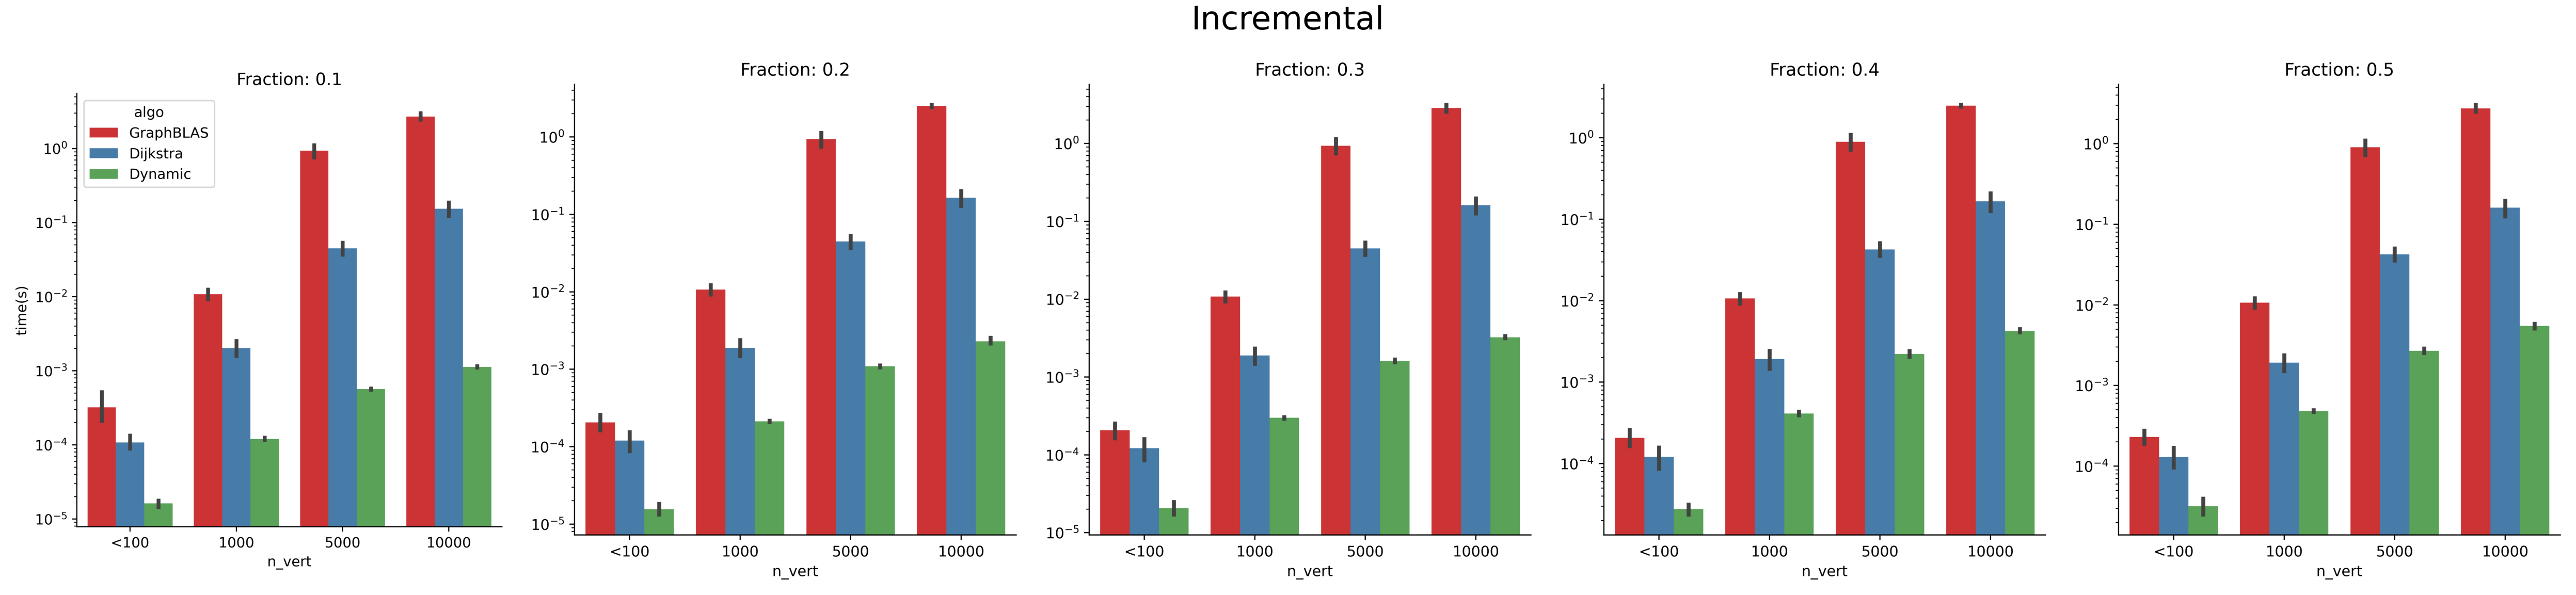

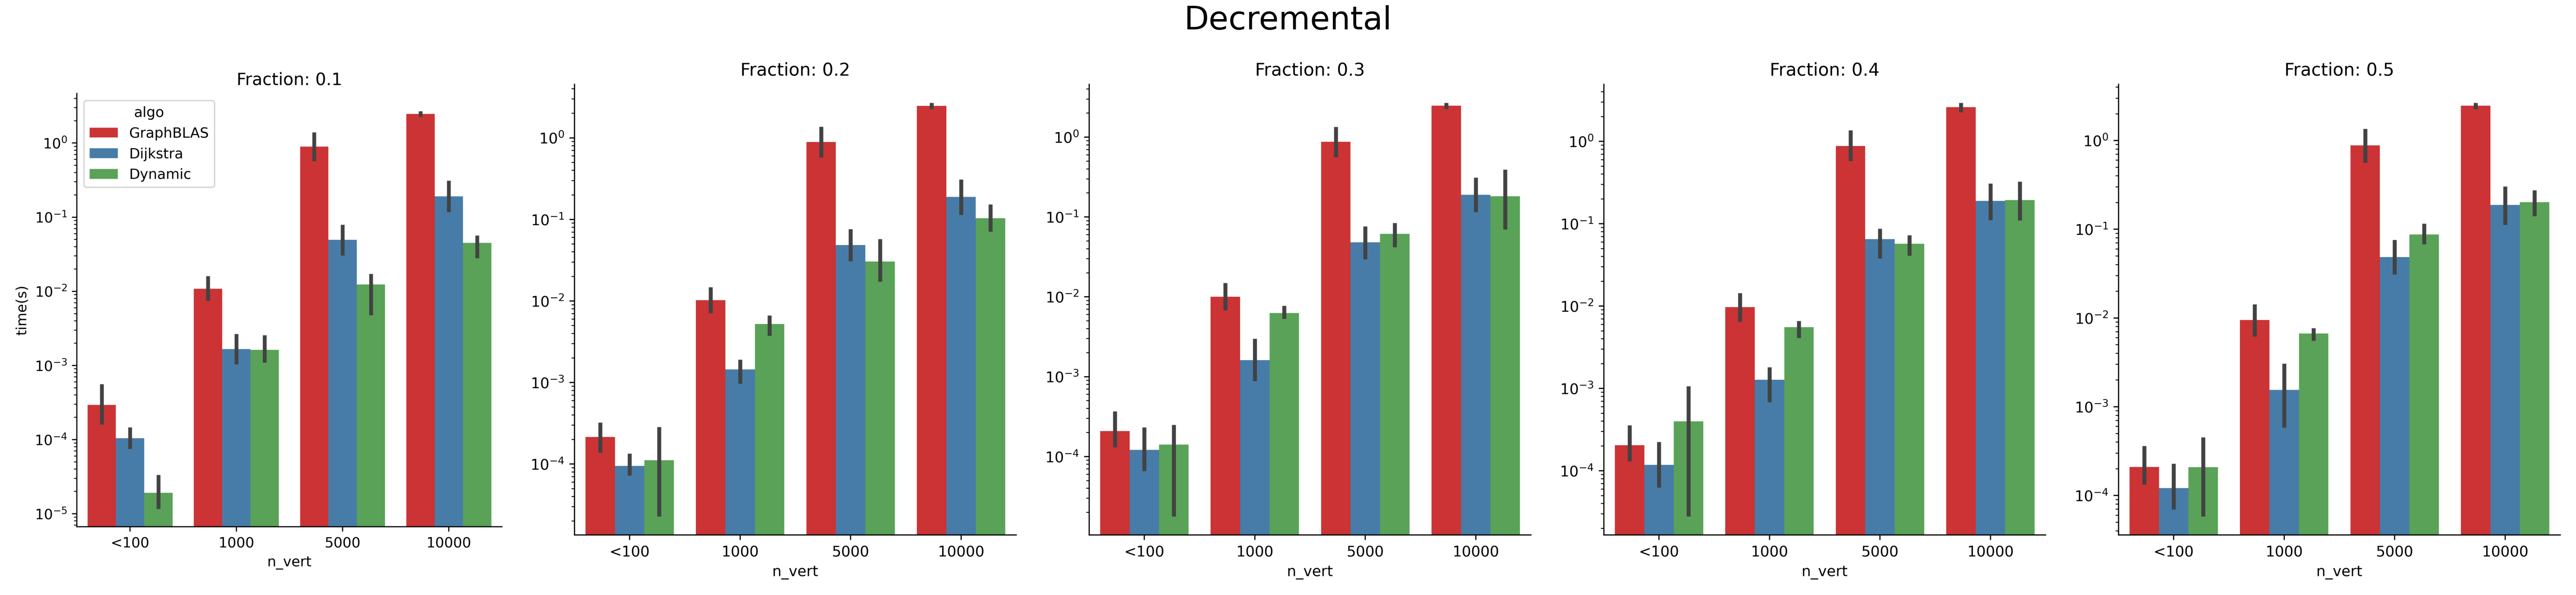

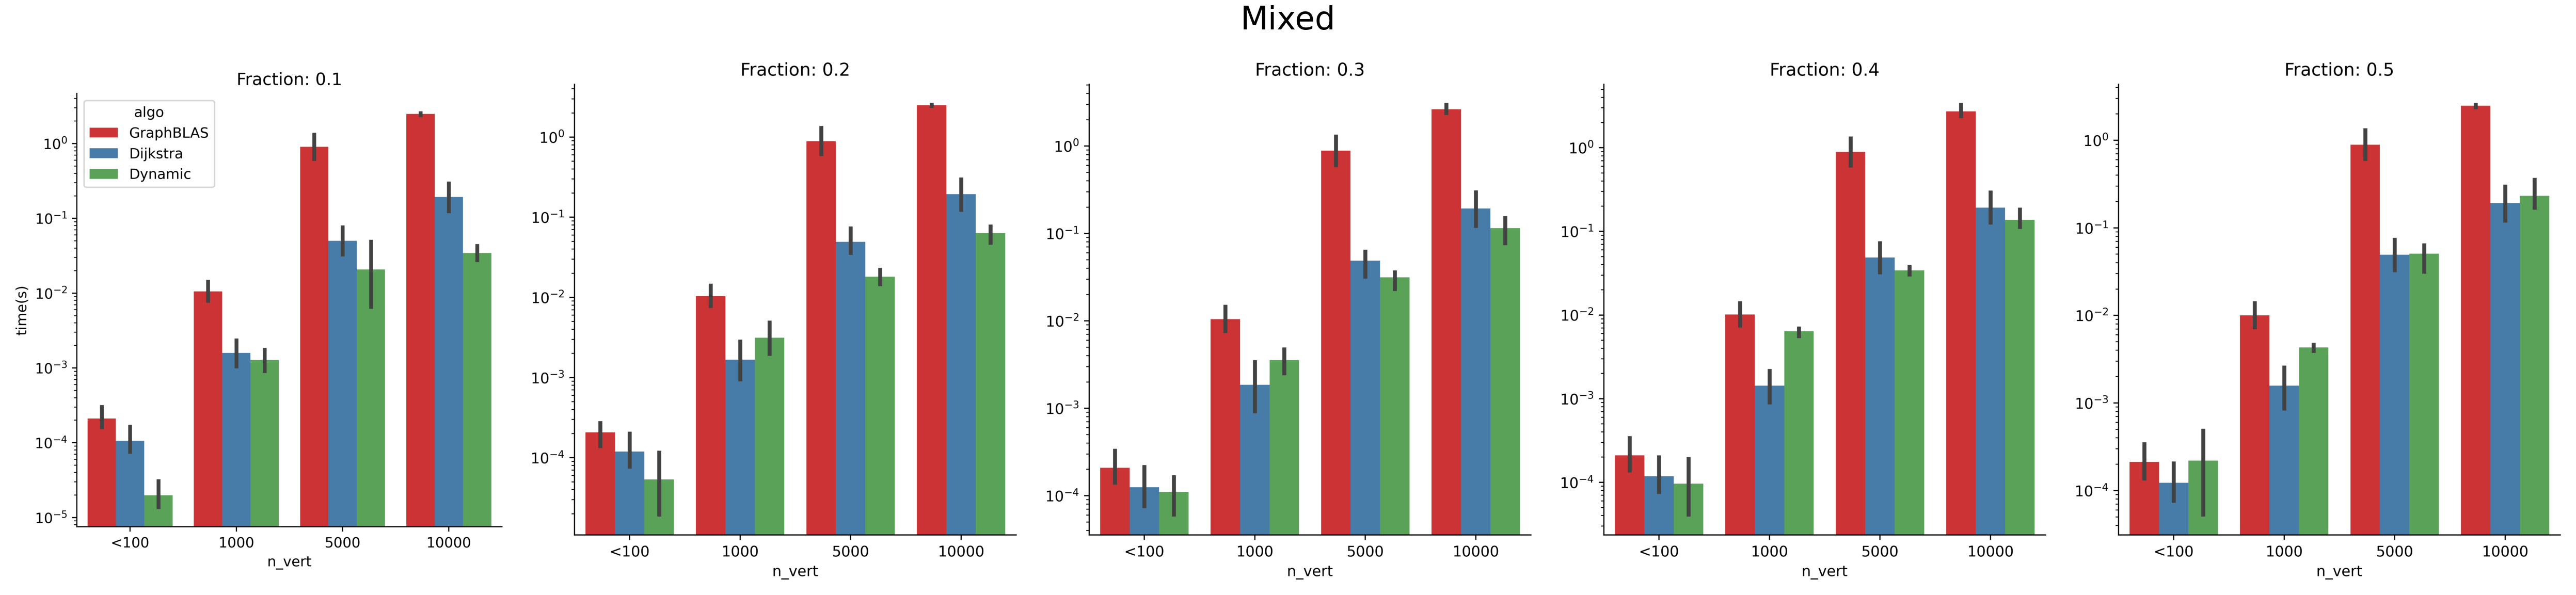

In [26]:
def show_plots():
    """
    Show detailed plots for algorithm performance comparison.
    """

    # Load results data from CSV
    results = pd.read_csv(results_file, names=["algo", "upd_type", "n_vert", "fraction", "time(s)"])

    # Group results data
    results_grouped = results.copy()
    results_grouped["n_vert"] = results_grouped["n_vert"].apply(lambda n: str(n) if n >= 1000 else "<100")

    for update_type in ["Incremental", "Decremental", "Mixed"]:
        plot_images = []
        for fraction in modified_edges_ratios:
            # Filter data for the current update type and fraction
            data_filtered = results_grouped[
                (results_grouped["upd_type"] == update_type[:3]) &
                (results_grouped["fraction"] == fraction)
            ]

            # Create bar plot using seaborn.catplot
            grid = sns.catplot(
                data=data_filtered,
                kind="bar",
                x="n_vert",
                y="time(s)",
                hue="algo",
                legend=fraction == modified_edges_ratios[0],
                legend_out=False,
                palette="Set1",
            )
            plt.title(f"Fraction: {fraction}")
            plt.yscale("log")

            if fraction != modified_edges_ratios[0]:
                grid.set_ylabels("")

            # Convert the plot to an image
            buf = io.BytesIO()
            grid.figure.savefig(buf, format="png", dpi=500, bbox_inches="tight")
            buf.seek(0)
            plot_images.append(Image.open(buf))
            plt.close()

        # Create subplots for displaying the images
        fig, axs = plt.subplots(
            ncols=len(modified_edges_ratios),
            figsize=(len(modified_edges_ratios) * 10, len(modified_edges_ratios) * 5),
        )
        for ax, plot_image in zip(axs, plot_images):
            ax.imshow(plot_image)
            ax.axis("off")
        fig.set_tight_layout(True)
        fig.suptitle(f"{update_type}", y=0.73, size=45)


show_plots()

## Выводы

Собранные выводы на основе предоставленных соображений:

1. Реализация алгоритма, использующего GraphBLAS, работает значительно медленнее двух других рассмотренных реализаций на всех размерах графа и множествах изменившихся ребер. Разрыв в производительности увеличивается с увеличением размера графа.

2. При инкрементальных обновлениях динамический алгоритм показывает лучшую производительность по сравнению с другими алгоритмами во всех рассмотренных случаях. Он работает в несколько раз быстрее классического алгоритма Дейкстры.

3. При декрементальных и смешанных обновлениях динамический алгоритм работает немного быстрее классического алгоритма Дейкстры на маленьких графах и небольших множествах изменившихся ребер, но замедляется на больших графах.

4. Отставание динамического алгоритма при удалении ребер можно объяснить двумя факторами: во-первых, удаление ребер требует больше изменений в структуре графа, чем их добавление, что влечет пересчет большего количества путей в динамическом алгоритме; во-вторых, рассмотренные изменения ребер являются случайными. В реальных сценариях изменения обычно имеют какую-то логику, что в теории может привести к лучшей производительности динамического алгоритма на таких графах.